# LSTM

## Caricamento del dataframe

In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("./runs/LSTM")

df = pd.read_csv("./framing_action.csv")
df.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.000000,0.000000,0.000000,-0.254745,-0.180888,0.529562,0.000000,0.000000,0.000000,-0.199201,...,-0.247262,-0.205080,0.502736,0.000000,0.000000,0.000000,-0.249076,-0.191259,0.480058,Prendi
1,0.188626,-0.124457,0.562990,-0.251265,-0.165891,0.534760,0.139340,-0.091834,0.614373,-0.195666,...,-0.243838,-0.190570,0.508365,0.187135,-0.141886,0.513036,-0.245797,-0.177189,0.485436,Prendi
2,0.187749,-0.098200,0.550945,-0.248171,-0.126271,0.533840,0.131223,-0.057304,0.596986,-0.187347,...,-0.241498,-0.166368,0.511143,0.188074,-0.132619,0.511210,-0.242174,-0.153959,0.487576,Prendi
3,0.188498,-0.076763,0.546801,-0.242461,-0.105347,0.531485,0.131638,-0.034524,0.591092,-0.181352,...,-0.243147,-0.153661,0.509436,0.182542,-0.121196,0.505738,-0.243236,-0.142064,0.485318,Prendi
4,0.186390,-0.062258,0.545261,-0.237655,-0.089744,0.533881,0.128792,-0.019735,0.587737,-0.176113,...,-0.237435,-0.133566,0.507988,0.183394,-0.101564,0.502848,-0.237633,-0.122870,0.483391,Prendi


In [2]:
class2idx = {
    "No_action": 0,
    "Prendi": 1,
    "Rilascia": 2,
    "Premi": 3
}

idx2class = {v: k for k, v in class2idx.items()}

In [3]:
df['TARGET'].replace(class2idx, inplace=True)

In [4]:
df.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.000000,0.000000,0.000000,-0.254745,-0.180888,0.529562,0.000000,0.000000,0.000000,-0.199201,...,-0.247262,-0.205080,0.502736,0.000000,0.000000,0.000000,-0.249076,-0.191259,0.480058,1
1,0.188626,-0.124457,0.562990,-0.251265,-0.165891,0.534760,0.139340,-0.091834,0.614373,-0.195666,...,-0.243838,-0.190570,0.508365,0.187135,-0.141886,0.513036,-0.245797,-0.177189,0.485436,1
2,0.187749,-0.098200,0.550945,-0.248171,-0.126271,0.533840,0.131223,-0.057304,0.596986,-0.187347,...,-0.241498,-0.166368,0.511143,0.188074,-0.132619,0.511210,-0.242174,-0.153959,0.487576,1
3,0.188498,-0.076763,0.546801,-0.242461,-0.105347,0.531485,0.131638,-0.034524,0.591092,-0.181352,...,-0.243147,-0.153661,0.509436,0.182542,-0.121196,0.505738,-0.243236,-0.142064,0.485318,1
4,0.186390,-0.062258,0.545261,-0.237655,-0.089744,0.533881,0.128792,-0.019735,0.587737,-0.176113,...,-0.237435,-0.133566,0.507988,0.183394,-0.101564,0.502848,-0.237633,-0.122870,0.483391,1


## Train - Validation - Test

Per creare il train-val-split, utilizziamo la seguente funzione:

In [5]:
def create_dataset(dataset, target, window_size = 2):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        dataX.append(dataset[i:i + window_size])
        dataY.append(target[(i + window_size):(i + window_size + 1)].values[0])
    return np.array(dataX), np.array(dataY)

Determiniamo la grandezza dei tre dataset.

In [6]:
train_size = int(len(df) * 0.7)
test_size = int((len(df) - train_size) * 0.6)
val_size = len(df) - train_size - test_size

print(train_size, test_size, val_size)

3469 892 595


In [7]:
train = df[0:train_size]
test = df[train_size:(len(df) - val_size)] 
val = df[(len(df) - val_size):len(df)]

print(train.shape[0], test.shape[0], val.shape[0])

3469 892 595


Separiamo le colonne delle features dall'etichetta.

In [8]:
train_label = train["TARGET"]
test_label = test["TARGET"]
val_label = val["TARGET"]

del train["TARGET"]
del test["TARGET"]
del val["TARGET"]

## Visualizzazione della distribuzione delle classi in Train, Val e Test

In [9]:
def get_class_distribution(obj):
    count_dict = {
        "No_action": 0,
        "Prendi": 0,
        "Rilascia": 0,
        "Premi": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['No_action'] += 1
        elif i == 1: 
            count_dict['Prendi'] += 1
        elif i == 2: 
            count_dict['Rilascia'] += 1
        elif i == 3: 
            count_dict['Premi'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

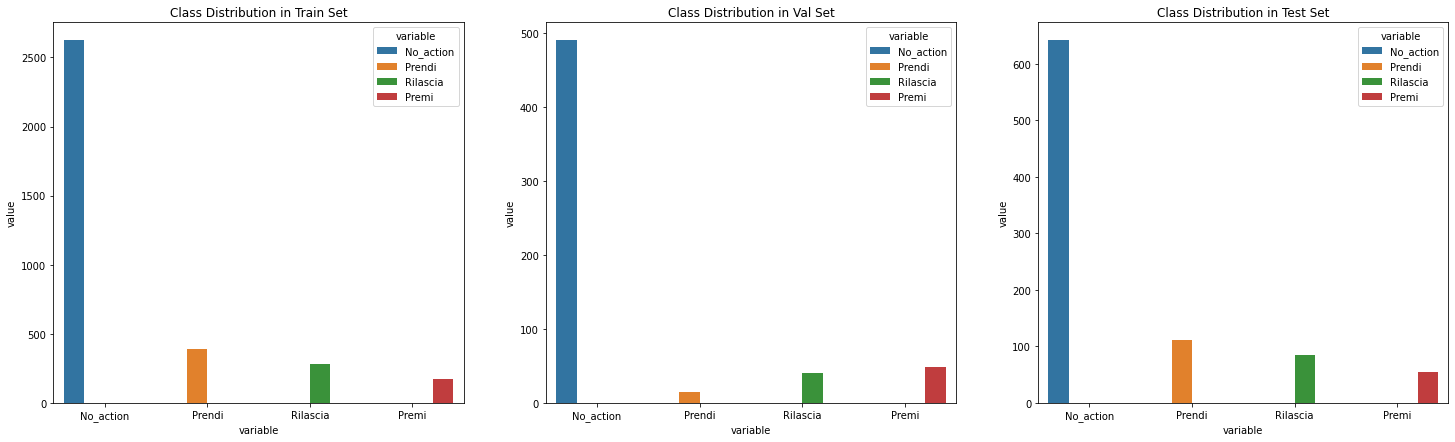

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [11]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [12]:
window_size = 33

In [13]:
train_X, train_Y = create_dataset(train, train_label, window_size)
train_dataset = ClassifierDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long())

test_X, test_Y = create_dataset(test, test_label, window_size)
test_dataset = ClassifierDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long())

val_X, val_Y = create_dataset(val, val_label, window_size)
val_dataset = ClassifierDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_Y).long())

## Weighted Sampling

Poiché c'è uno squilibrio di classe, utilizziamo la suddivisione stratificata per creare i nostri set di train, convalida e test.

In [14]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

Quindi, otteniamo il conteggio di tutte le classi nel nostro set di allenamento.  Usiamo il reciproco di ogni conteggio per ottenere il suo peso.  Ora che abbiamo calcolato i pesi per ogni classe, possiamo procedere.

In [15]:
class_count = [i for i in get_class_distribution(train_label).values()]
#class_count[0] *= 1.5
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
 
print(class_weights)

tensor([0.0004, 0.0026, 0.0035, 0.0057])


WeightedRandomSampler prevede un peso per ogni campione.  Lo usiamo come segue.

In [16]:
class_weights_all = class_weights[target_list]

Infine, inizializziamo il nostro WeightedRandomSampler.  Lo chiameremo nel nostro dataloader in seguito.

In [17]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

## Parametri del modello

In [18]:
EPOCHS = 50
BATCH_SIZE = 256
LEARNING_RATE = 0.0002
NUM_FEATURES = len(df.columns)-1
NUM_CLASSES = 4

## Dataloader

In [19]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=weighted_sampler)

val_loader = DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

## Rete Neurale LSTM

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size=4, hidden_layer_size=117, num_layers=2):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size 
        self.rnn = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.layer_1 = nn.Linear(hidden_layer_size, 60)
        #self.layer_2 = nn.Linear(78, 39)
        #self.layer_3 = nn.Linear(39, 16)
        self.layer_out = nn.Linear(60, output_size) 
        #self.regressor = nn.Linear(hidden_layer_size, output_size)
        
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(hidden_layer_size)
        self.batchnorm2 = nn.BatchNorm1d(60)
        #self.batchnorm3 = nn.BatchNorm1d(16)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        h, _ = self.rnn(x, (h0, c0)) #h contiene i valori di tutti gli output
        h = h[:,-1,:] #seleziona l'ultimo output
        #h = h.squeeze(1) #trasforma la shape da bs x 1 x hidden_size a bs x hidden_size
        h = h.view(-1, self.hidden_size)
        h = self.batchnorm1(h)
        h = self.relu(h)
        
        h = self.layer_1(h)
        h = self.batchnorm2(h)
        h = self.relu(h)
        
        #h = self.layer_2(h)
        #h = self.batchnorm2(h)
        #h = self.tanh(h)
        #h = self.dropout(h)
        
        #h = self.layer_3(h)
        #h = self.batchnorm3(h)
        #h = self.tanh(h)
        #h = self.dropout(h)
        
        h = self.layer_out(h)
        #h = h.view(-1, 4)
        #h = self.regressor(h)
        return h

In [21]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, output_size=4, hidden_layer_size=117, num_layers=1):
        super(LSTMCell, self).__init__()
        self.num_layers = num_layers
        self.hidden_layer_size = hidden_layer_size 
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.layer_1 = nn.Linear(hidden_layer_size, 60)
        self.layer_out = nn.Linear(60, output_size) 
        
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(hidden_layer_size)
        self.batchnorm2 = nn.BatchNorm1d(60)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_layer_size).to(device)
        output, (h, c) = self.lstm(x, (h0, c0))
        h = h.view(-1, self.hidden_layer_size) #reshaping the data for Dense layer next
        h = self.batchnorm1(h)
        h = self.relu(h)
        h = self.layer_1(h)
        h = h.view(-1, 60)
        h = self.batchnorm2(h)
        h = self.relu(h)
        h = self.layer_out(h)
        return h

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
device

device(type='cpu')

In [24]:
model = LSTM(input_size=NUM_FEATURES, output_size=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

print(model)

LSTM(
  (rnn): LSTM(156, 117, num_layers=2, batch_first=True)
  (layer_1): Linear(in_features=117, out_features=60, bias=True)
  (layer_out): Linear(in_features=60, out_features=4, bias=True)
  (relu): ReLU()
  (batchnorm1): BatchNorm1d(117, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train the model

Prima di iniziare il nostro addestramento, definiamo una funzione per calcolare la precisione per epoca.

Questa funzione accetta y_pred e y_test come argomenti di input.  Quindi applichiamo log_softmax a y_pred ed estraiamo la classe che ha una probabilità maggiore.

Successivamente, confrontiamo le classi previste e le classi effettive per calcolare l'accuratezza.

In [25]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

Definiremo anche 2 dizionari che memorizzeranno l'accuratezza/epoca e la perdita/epoca sia per il treno che per i set di convalida.

In [26]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

In [27]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))        
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    writer.add_scalars("Loss/train_val", {
        "train": train_epoch_loss/len(train_loader),
        "val": val_epoch_loss/len(val_loader),
    }, e)
    writer.add_scalars("Acc/train_val", {
        "train": train_epoch_acc/len(train_loader),
        "val": val_epoch_acc/len(val_loader),
    }, e)
    writer.flush()
    print(f'Epoch {e+0:03}:\
          | Train Loss: {train_epoch_loss/len(train_loader):.5f}\
          | Val Loss: {val_epoch_loss/len(val_loader):.5f}\
          | Train Acc: {train_epoch_acc/len(train_loader):.3f}\
          | Val Acc: {val_epoch_acc/len(val_loader):.3f}')
writer.close()
print("Done.")

Begin training.


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001:          | Train Loss: 1.02062          | Val Loss: 1.31013          | Train Acc: 61.929          | Val Acc: 84.875
Epoch 002:          | Train Loss: 0.85949          | Val Loss: 1.29147          | Train Acc: 68.929          | Val Acc: 55.516
Epoch 003:          | Train Loss: 0.76294          | Val Loss: 1.25893          | Train Acc: 72.071          | Val Acc: 57.473
Epoch 004:          | Train Loss: 0.70187          | Val Loss: 1.15405          | Train Acc: 72.929          | Val Acc: 64.057
Epoch 005:          | Train Loss: 0.67825          | Val Loss: 0.94181          | Train Acc: 74.429          | Val Acc: 66.192
Epoch 006:          | Train Loss: 0.60089          | Val Loss: 0.88722          | Train Acc: 77.071          | Val Acc: 71.886
Epoch 007:          | Train Loss: 0.53466          | Val Loss: 0.73444          | Train Acc: 79.357          | Val Acc: 70.463
Epoch 008:          | Train Loss: 0.49629          | Val Loss: 0.73344          | Train Acc: 80.500          | 

## Visualizzazione Loss e Accuracy

Per tracciare i grafici delle linee di perdita e accuratezza, creiamo nuovamente un dataframe dai dizionari precision_stats e loss_stats.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

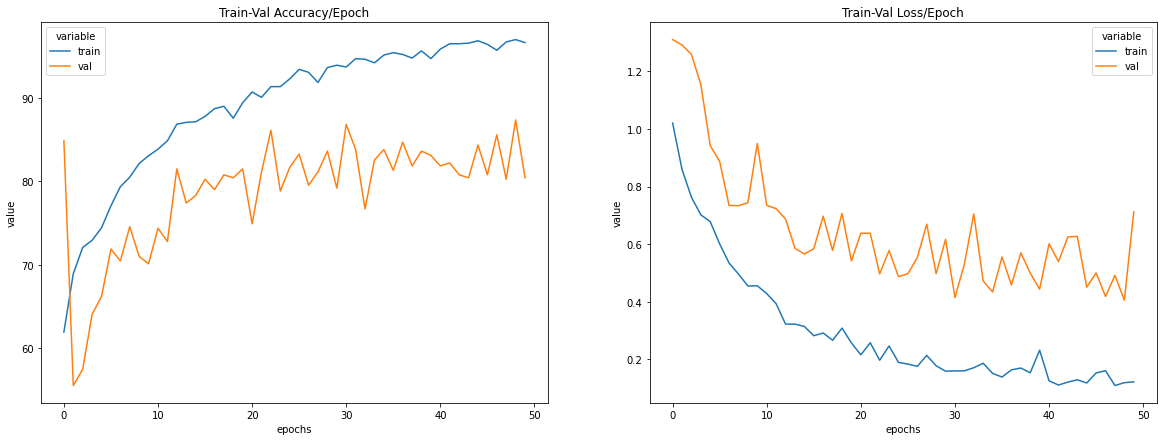

In [28]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

## Test the model

Al termine dell'addestramento, dobbiamo testare come si è comportato il nostro modello.  Nota che abbiamo usato model.eval() prima di eseguire il nostro codice di test.  Per dire a PyTorch che non vogliamo eseguire la retropropagazione durante l'inferenza, usiamo torch.no_grad(), proprio come abbiamo fatto per il ciclo di convalida sopra.

Iniziamo definendo un elenco che conterrà le nostre previsioni.  Quindi eseguiamo il ciclo dei nostri batch utilizzando test_loader.

In [29]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

## Confusion Matrix

Creiamo un dataframe dalla matrice di confusione e lo tracciamo come una mappa di calore utilizzando la libreria Seaborn.

<AxesSubplot:>

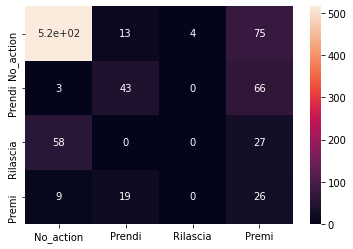

In [30]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_Y, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [31]:
print(classification_report(test_Y, y_pred_list))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       608
           1       0.57      0.38      0.46       112
           2       0.00      0.00      0.00        85
           3       0.13      0.48      0.21        54

    accuracy                           0.68       859
   macro avg       0.40      0.43      0.38       859
weighted avg       0.71      0.68      0.68       859

